In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt 

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.util import deprecations
deprecations.SILENCE_UBER_WARNING = True

In [4]:
# Create a reference to the file. 
file= "./Resources/hawaii.sqlite" 
conn_str=f"sqlite:///{file}"

In [5]:
# create engine to hawaii.sqlite
engine = create_engine(conn_str)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [9]:
inspector = inspect(engine)
tables=inspector.get_table_names()
for table in tables:
    print (table)

measurement
station


In [10]:
columns = inspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
#use engine.execute to display the first 10 rows from the measurement table
engine.execute("select * from measurement limit 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
#use engine.execute to display the first 10 rows from the station table
engine.execute("select * from station limit 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
latest_dt =session.query(measurement.date).order_by(measurement.date.desc()).first()
print("Latest date in database: " ,latest_dt)

Latest date in database:  ('2017-08-23',)


In [16]:
# Design a query to retrieve the last 12 months of precipitation data 
result = session.query(measurement.date,func.avg(measurement.prcp)).\
    filter(measurement.date >= '2016-08-23').\
    group_by(measurement.date).all()
result

[('2016-08-23', 0.45166666666666666),
 ('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.276),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333332),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285715),
 ('2016-09-17', 0.13599999999999998),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 

In [17]:
#Save the query results as a Pandas DataFrame. Explicitly set the column names
df=pd.DataFrame(result, columns= ["Date", "Precipitation"])
df.set_index("Date", inplace=True)
df=df.sort_values(by = 'Date')
df.head ()

,Precipitation
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


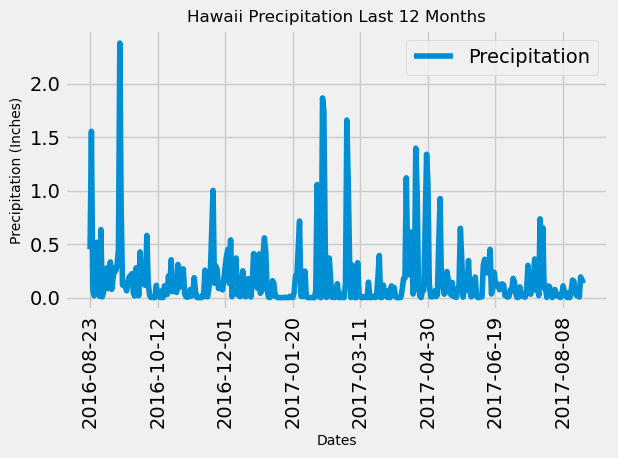

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind="line",rot=90)
plt.title("Hawaii Precipitation Last 12 Months", size=12)
plt.ylabel("Precipitation (Inches)", size=10)
plt.xlabel("Dates", fontsize=10)
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()                          

9

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_station= session.query(measurement.station , func.count(measurement.station)).\
                    group_by( measurement.station ).\
                    order_by(func.count(measurement.station).desc()).all()
active_station 
# Which station has the highest number of observations? USC00519281 with 2772 observations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
best_station= active_station[0][0]
temp_active_station=session.query(func.min(measurement.tobs), func.max(measurement.tobs),func.avg(measurement.tobs)).\
                      filter(measurement.station == best_station).all()


print("The Minimum ,Maximum and Average Temperatures for the most active station is :" ,temp_active_station)

The Minimum ,Maximum and Average Temperatures for the most active station is : [(54.0, 85.0, 71.66378066378067)]


In [23]:
year_ago= dt.date(2017, 8, 18) - dt.timedelta(days = 365)
print("Date one year ago is: ", year_ago)

Date one year ago is:  2016-08-18


In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result=session.query(measurement.station,measurement.tobs).\
                filter(measurement.station == best_station).\
                filter(measurement.date >= year_ago).all()
result
tobs_df =pd.DataFrame(result)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,80.0
USC00519281,79.0
USC00519281,81.0
USC00519281,79.0
USC00519281,78.0


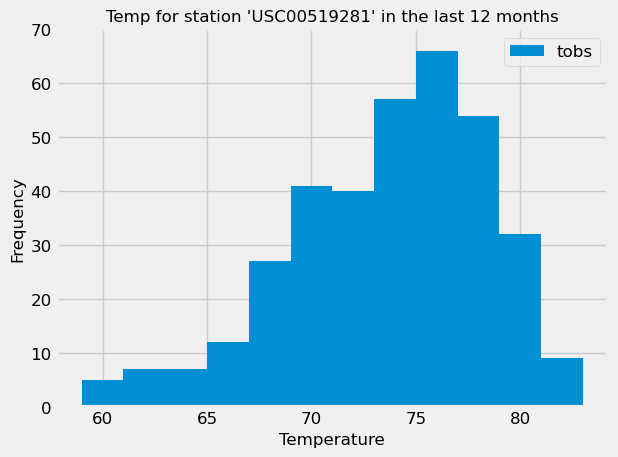

In [25]:
#plot the results as a histogram
tobs_df.plot.hist(bins=12)
plt.title("Temp for station 'USC00519281' in the last 12 months", size=12)
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Frequency", fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.ylim(0,70)
plt.show()

# Close Session

In [26]:
# Close Session
session.close()